In [40]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Annotated 
from pydantic import BaseModel,Field
import operator





In [41]:
load_dotenv()

True

In [42]:
model =ChatOpenAI(model='gpt-4o-mini')

In [43]:
class EvaluationInput(BaseModel):
    feedback:str=Field(description="Detailed feedback on the essays, highlighting strengths and areas for improvement.")
    score:int=Field(description="A score between 1 and 10, where 10 indicates an excellent essay and 1 indicates a poor essay.",ge=1,le=10)

In [44]:
structured_model= model.with_structured_output(EvaluationInput)

In [45]:
essays='''Loneliness is often spoken of as a wound—an absence, a hollow echo in a crowded world. Yet there is another way to see it. Loneliness, when embraced rather than feared, becomes not a curse but a cathedral: vast, quiet, and sacred. It is in solitude that the soul learns its own shape.

From childhood, we are taught to measure our worth by noise—by friendships, applause, constant connection. Silence is treated like a symptom to cure. But loneliness is not the same as abandonment. It is the deliberate turning inward, the courageous decision to sit alone with one's thoughts. In that stillness, the mind unfolds. Ideas rise that would have drowned in conversation. Emotions clarify. We discover which fears are truly ours and which were inherited from the crowd.

The greatest acts of creation have often emerged from solitude. A writer alone with a blank page. A painter before an empty canvas. A thinker pacing in a quiet room. Loneliness is the furnace in which originality is forged. Without it, we risk becoming echoes of each other—repeating, reshaping, but never truly originating.

There is also a fierce dignity in standing alone. To be comfortable in one’s own company is a form of independence. It means that validation is no longer borrowed; it is generated from within. A lonely person who has learned to love their solitude carries an unshakable center. They are not easily manipulated by trends or swayed by shallow approval. They know who they are when no one is watching.

Loneliness deepens our capacity for connection as well. When we have sat with our own thoughts, when we have confronted our own vulnerabilities, we meet others not out of desperation but out of choice. Relationships become richer because they are no longer attempts to escape ourselves. Instead, they are bridges built between two whole worlds.

There is beauty in the quiet evening spent alone, in the slow realization that one’s thoughts are sufficient company. There is strength in walking a path that others do not see. And there is a profound, almost luminous clarity that emerges when we stop fearing the empty room.

To glorify loneliness is not to reject love or community. It is to recognize that solitude is the soil from which both grow. In the silence, we become. In the aloneness, we awaken. And in embracing loneliness, we discover that we were never truly empty—only undiscovered.'''


In [46]:
prompt=f'''You are an expert essay evaluator. Please read the following essay and provide detailed feedback on its strengths and areas for improvement. Additionally, assign a score between 1 and 10, where 10 indicates an excellent essay and 1 indicates a poor essay.\n {essays}'''

structured_model.invoke(prompt).feedback

c:\Users\lamic\Desktop\LangGraph-Core-Components\myenv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationInput(feedback=...of the topic.', score=8), input_type=EvaluationInput])
  return self.__pydantic_serializer__.to_python(


'Strengths:\n1. **Original Imagery:** The essay opens with a striking metaphor that immediately captures attention. The comparison of loneliness to a wound and then to a cathedral is powerful and sets a reflective tone.\n2. **Thoughtful Perspective:** The essay provides a unique view on loneliness, advocating for its acceptance and exploration rather than its avoidance, which challenges conventional assumptions.\n3. **Cohesive Structure:** Each paragraph flows logically into the next, building on the central theme of embracing solitude and its benefits, which makes the argument compelling.\n4. **Rich Language:** The use of poetic language and varied sentence structure enriches the reading experience, making abstract concepts more tangible and engaging.\n5. **Philosophical Depth:** The essay invokes deeper thoughts on identity and connection, encouraging introspection and resonating with many readers’ experiences of loneliness.\n\nAreas for Improvement:\n1. **Examples and Evidence:** Wh

In [47]:
class LoksewaState(TypedDict):
    essay:str
    language_feedback:int
    depth_of_analysis_feedback:int
    clarity_of_expression_feedback:int
    overall_feedback:int
    individual_score:Annotated[list[int],operator.add]
    avg_score:float

In [48]:
def evaluate_language(state:LoksewaState):
    prompt=f"   Evaluate the language used in the following essay and provide a score between 1 and 10, where 10 indicates excellent language use and 1 indicates poor language use. Essay: {state['essay']}"
    output=structured_model.invoke(prompt)
    return {'language_feedback':output.feedback,'individual_score':[output.score]}


In [49]:
def evaluate_depth_of_analysis(state:LoksewaState):
    prompt=f"   Evaluate the depth of analysis in the following essay and provide a score between 1 and 10, where 10 indicates excellent depth of analysis and 1 indicates poor depth of analysis. Essay: {state['essay']}"
    output=structured_model.invoke(prompt)
    return {'depth_of_analysis_feedback':output.feedback,'individual_score':[output.score]}


In [50]:
def evaluate_clarity_of_expression(state:LoksewaState):
    prompt=f"   Evaluate the clarity of expression in the following essay and provide a score between 1 and 10, where 10 indicates excellent clarity of expression and 1 indicates poor clarity of expression. Essay: {state['essay']}"
    output=structured_model.invoke(prompt)
    return {'clarity_of_expression_feedback':output.feedback,'individual_score':[output.score]}


In [51]:
def final_evaluation(state:LoksewaState):
    prompt=f" Based on the following essay and the feedback provided on language \n language feedback, depth of analysis-, and clarity of expression, provide an overall evaluation of the essay. Assign a final score between 1 and 10, where 10 indicates an excellent essay and 1 indicates a poor essay. Essay: {state['essay']} Language Feedback: {state['language_feedback']} Depth of Analysis Feedback: {state['depth_of_analysis_feedback']} Clarity of Expression Feedback: {state['clarity_of_expression_feedback']}"
    overall_feedback=model.invoke(prompt).content

    avg_score=sum(state['individual_score'])/len(state['individual_score'])

    return{'overall_feedback':overall_feedback,'avg_score':avg_score}




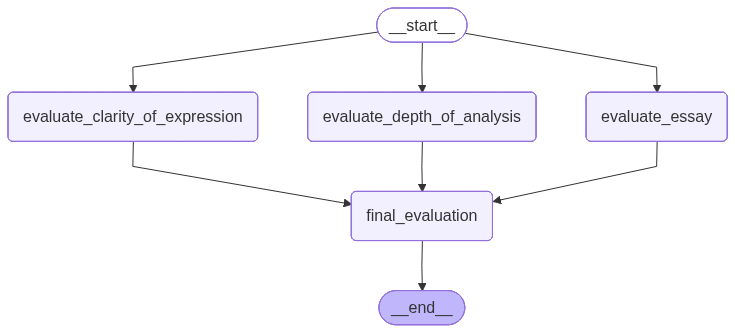

In [52]:
graph=StateGraph(LoksewaState)

graph.add_node('evaluate_essay',evaluate_language)
graph.add_node('evaluate_depth_of_analysis',evaluate_depth_of_analysis)
graph.add_node('evaluate_clarity_of_expression',evaluate_clarity_of_expression)
graph.add_node('final_evaluation',final_evaluation) 

graph.add_edge(START,'evaluate_essay')
graph.add_edge(START,'evaluate_depth_of_analysis')
graph.add_edge(START,'evaluate_clarity_of_expression')


graph.add_edge('evaluate_essay','final_evaluation')
graph.add_edge('evaluate_depth_of_analysis','final_evaluation')
graph.add_edge('evaluate_clarity_of_expression','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow=graph.compile()
workflow



In [55]:
initial_state={
    'essay': essays2
}
workflow.invoke(initial_state)

c:\Users\lamic\Desktop\LangGraph-Core-Components\myenv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationInput(feedback=...uture essays.', score=2), input_type=EvaluationInput])
  return self.__pydantic_serializer__.to_python(
c:\Users\lamic\Desktop\LangGraph-Core-Components\myenv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationInput(feedback=... effectively.", score=2), input_type=EvaluationInput])
  return self.__pydantic_serializer__.to_python(
c:\Users\lamic\Desktop\LangGraph-Core-Components\myenv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - ser

{'essay': '\nThis essay is about things, and also other things too. There are many things in the world. Some things are good but others are not as good, which is interesting because it shows how things can be different from other things. In conclusion, things matter.\n\nFirst of all, since the beginning of time, people have always been doing things. For example, in ancient times, people did historical things that were very historical. This proves that history happened in the past. Also, the future has not happened yet, which is why it is called the future.\n\nAnother important point is that society is made of people. Without people, society would not have anyone in it. This is a strong example of how important people are to society and vice versa. In many ways, this connects to everything.\n\nFurthermore, technology is technological. Phones are phone-shaped devices that people use to call people on the phone. This has changed the world in many ways, especially because it changed things

In [54]:
essays2='''
This essay is about things, and also other things too. There are many things in the world. Some things are good but others are not as good, which is interesting because it shows how things can be different from other things. In conclusion, things matter.

First of all, since the beginning of time, people have always been doing things. For example, in ancient times, people did historical things that were very historical. This proves that history happened in the past. Also, the future has not happened yet, which is why it is called the future.

Another important point is that society is made of people. Without people, society would not have anyone in it. This is a strong example of how important people are to society and vice versa. In many ways, this connects to everything.

Furthermore, technology is technological. Phones are phone-shaped devices that people use to call people on the phone. This has changed the world in many ways, especially because it changed things from how they used to be before they were changed.

In conclusion, there are many conclusions that could be concluded from this essay. The main one is that everything is connected to other things in ways that are both similar and different. Therefore, this essay has explained the topic clearly and in detail.


'''